In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../agent/cleaned_data/FANG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,19.459999,19.920000,18.600000,19.240000,18.924437,189700
1,1/3/2013,19.240000,19.459999,18.650000,19.139999,18.826073,89100
2,1/4/2013,19.250000,20.490000,18.969999,20.049999,19.721148,173300
3,1/7/2013,19.889999,21.240000,19.639999,20.770000,20.429340,210300
4,1/8/2013,20.690001,21.100000,20.379999,20.600000,20.262127,229400


In [3]:
def buy_stock(
    real_movement,
    delay = 5,
    initial_state = 1,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    delay_change_decision = delay
    current_decision = 0
    state = initial_state
    current_val = real_movement[0]
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    if state == 1:
        initial_money, current_inventory = buy(
            0, initial_money, current_inventory
        )

    for i in range(1, real_movement.shape[0], 1):
        if real_movement[i] < current_val and state == 0:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 1
                initial_money, current_inventory = buy(
                    i, initial_money, current_inventory
                )
                current_decision = 0
                states_buy.append(i)
        if real_movement[i] > current_val and state == 1:
            if current_decision < delay_change_decision:
                current_decision += 1
            else:
                state = 0

                if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
                else:
                    if current_inventory > max_sell:
                        sell_units = max_sell
                    else:
                        sell_units = current_inventory
                    current_inventory -= sell_units
                    total_sell = sell_units * real_movement[i]
                    initial_money += total_sell
                    try:
                        invest = (
                            (real_movement[i] - real_movement[states_buy[-1]])
                            / real_movement[states_buy[-1]]
                        ) * 100
                    except:
                        invest = 0
                    print(
                        'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                        % (i, sell_units, total_sell, invest, initial_money)
                    )

                current_decision = 0
                states_sell.append(i)
        current_val = real_movement[i]
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [4]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, initial_state = 1, 
                                                         delay = 4, initial_money = 10000)

day 0: buy 1 units at price 19.240000, total balance 9980.760000
day 8, sell 1 units at price 21.799999, investment 13.305611 %, total balance 10002.559999,
day 14: buy 1 units at price 21.430000, total balance 9981.129999
day 23, sell 1 units at price 22.629999, investment 5.599621 %, total balance 10003.759998,
day 33: buy 1 units at price 21.280001, total balance 9982.479998
day 41, sell 1 units at price 22.389999, investment 5.216159 %, total balance 10004.869997,
day 51: buy 1 units at price 23.990000, total balance 9980.879997
day 57, sell 1 units at price 25.650000, investment 6.919549 %, total balance 10006.529997,
day 72: buy 1 units at price 25.799999, total balance 9980.729998
day 81, sell 1 units at price 26.260000, investment 1.782950 %, total balance 10006.989998,
day 102: buy 1 units at price 34.950001, total balance 9972.039997
day 115, sell 1 units at price 35.009998, investment 0.171667 %, total balance 10007.049995,
day 132: buy 1 units at price 37.250000, total bala

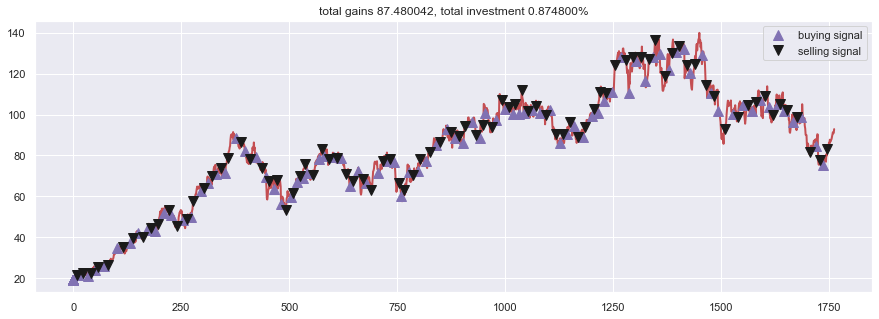

In [5]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()